In [1]:
import os, time
import numpy as np
import pickle
from copy import deepcopy
from sklearn.decomposition import PCA
from tqdm import tqdm

# Pytorch
import torch
use_cuda = False
if torch.cuda.is_available() and use_cuda:
    device = torch.device('cuda')
    print("Use cuda.")
else:
    device = torch.device('cpu')
    print("Use cpu.")
to_dev = lambda arr: (torch.from_numpy(arr).to(device)
                       if type(arr) == np.ndarray else arr.to(device))

# Figures 
from specs import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

from helpers import Arrow3D

from task_generators import cycling as gen_task
from rnn_model_dt import RNN_Net

Use cpu.


In [2]:
# Choose task
i_task = 1
task_name = [
    "cycling",
    "flipflop",
    "mante",
    "romo",
    "complex_sine",
][i_task]
task_lbl = [
    "Cycling",
    "3-bit flipflop",
    "Mante",
    "Romo",
    "Complex sine",
][i_task]
file_name = "neuro_noisy_" + task_name + "_n_512" + ".pkl"

# Whether to add neural noise 
with_noise = False

# Load data
data_file = data_path + file_name
print(task_name)
with open(data_file, 'rb') as handle:
    res = pickle.load(handle)
[
    n_steps, n_samples, gs, out_scales, n_sce, opt_gens, lr0s, n_mi, dim_hid, dim_in, dim_out, 
    dt, rec_step_dt, n_layers, bias, train_in, train_hid, train_out, train_layers, nonlin, 
    gaussian_init, h_0_std, noise_input_std, noise_init_std, noise_hid_std, batch_size, 
    task_params, task_params_ev, n_t_ev, task_ev, n_if, n_ifn, steps, loss_all, 
    output_all, _, #hids_all, 
    h_0_all, sd_if_all, 
] = res[:38]
del res
print('Loaded from ', data_file)

flipflop
Loaded from  ../data/neuro_noisy_flipflop_n_512.pkl


In [17]:
### Run simulation with longer time for plotting
from task_generators import cycling, flipflop, mante, romo, complex_sine
task_gens = [cycling, flipflop, mante, romo, complex_sine]
task_generator = task_gens[i_task]
if task_name == "flipflop":
    task_params["t_max"] = 150
    
# Task generators and fixed eval task
task_gen = task_generator(dim_in, dim_out, dt, **task_params)
task_params_ev = deepcopy(task_params)
task_gen_ev = task_generator(dim_in, dim_out, dt, **task_params_ev)
ts_ev, input_ev, target_ev, mask_ev = task_gen_ev(batch_size)
noise_input_ev = noise_input_std * np.float32(np.random.randn(*input_ev.shape)) / np.sqrt(dt)
noise_init_ev = noise_init_std * np.float32(np.random.randn(n_layers-1, batch_size, dim_hid)) 
n_t_ev = len(ts_ev)
task_ev = ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev

# Hidden state noise. For initial and input, we use the frozen arrays!
noise_hid_std_ex = noise_hid_std

# Task
ts_ex, input_ex, target_ex, mask_ex, noise_input_ex, noise_init_ex = [to_dev(arr) for arr in task_ev]

# Times for plotting
n_t_pl = n_t_ev
t_pc_min = 5
n_t_pc_min = int(t_pc_min / (dt * rec_step_dt))
n_t_pc_max = n_t_pl
t_pc_max = n_t_pl * (dt * rec_step_dt)
n_t_pc = n_t_pc_max - n_t_pc_min

# Results arrays
n_comp = 3
h_proj_pl = np.zeros((*n_mi, batch_size, n_t_pl, n_comp))
for mi in tqdm(np.ndindex(*n_mi)):
    i_s, i_sce = mi
    out_scale = out_scales[i_sce]
    g = gs[i_sce]
    # Network instance
    net = RNN_Net(dim_in, dim_hid, dim_out, n_layers, nonlin, bias, out_scale, g, gaussian_init, 
                  dt, rec_step_dt, train_layers)
    net.load_state_dict(sd_if_all[1][mi])
    h_0 = h_0_all[mi]
    # Transfer
    net.to(device)
    h_0 = h_0.to(device)
    with torch.no_grad():
        output_ex, hids_ex = net.forward_hid(input_ex + noise_input_ex, 
                                       h_0 + noise_init_ex, 
                                       noise_hid_std_ex)

    h = hids_ex[:, n_t_pc_min:n_t_pc_max].reshape(-1, dim_hid)
    pca = PCA(n_comp)
    pca.fit(h)
    ps = pca.components_
    h_proj_pl[mi] = hids_ex.numpy() @ ps.T

20it [00:15,  1.30it/s]


Save figure to ../figures/fig_19_flipflop_pca_samples.both


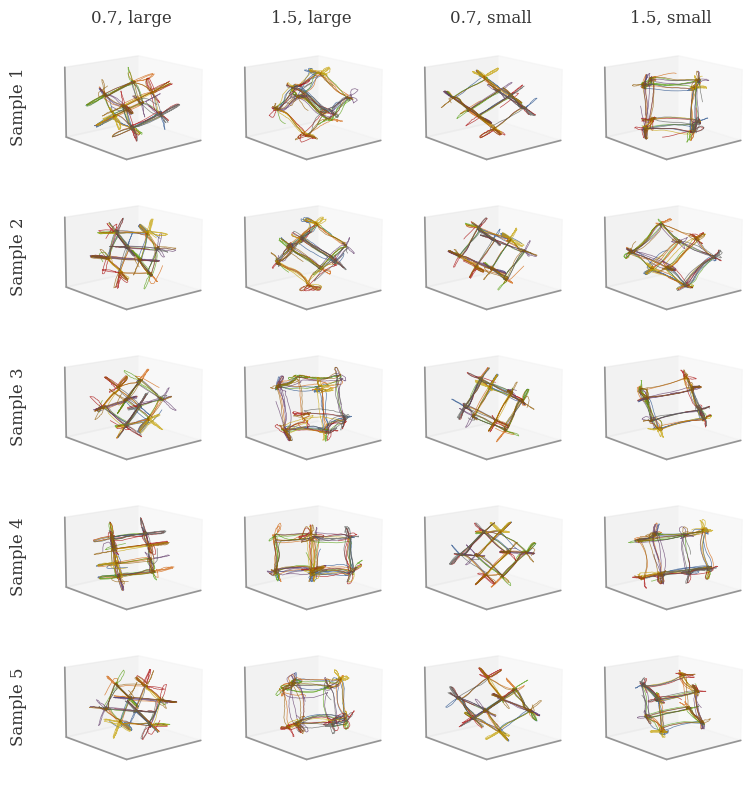

In [27]:
# Select globally what to plot
b_show = np.arange(8)
n_show = len(b_show)
sce_plt = np.arange(n_sce)
sce_lbls = ["%.1f, %s" % (gs[i], out_scales[i]) for i in range(n_sce)]
# sce_plt = np.array([3, 1])
# sce_lbls = np.array(["Aligned", "Oblique"])
n_sce_plt = len(sce_plt)

## Plot PCA
samples_plt_a = np.arange(n_samples)
n_rows = len(samples_plt_a)
n_cols = n_sce_plt

fig_width = 1.8 * n_cols
fig_height = 1.5 * n_rows
fig = plt.figure(figsize=(fig_width, fig_height), facecolor='w')
plot_3d = True
dim_p = 2 + plot_3d
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.)
axes = np.array([[fig.add_subplot(gs0[k, j], projection='3d' if plot_3d else None)
                      for j in range(n_cols)] for k in range(n_rows)])


# ts_pl, input_pl, target_pl, mask_pl, _, _ = task_pl
for i_r, i_bs, i_c in np.ndindex(n_rows, n_show, n_cols):
    ax = axes[i_r, i_c]
    i_s = samples_plt_a[i_r]
    i_sce = sce_plt[i_c]
    mi = i_s, i_sce
    alpha = 0.7
    i_b = b_show[i_bs]
    
    # PCA
    h_proj = h_proj_pl[i_s, i_sce, i_b]
    c = colors[i_bs]
    ax.plot(*h_proj[n_t_pc_min:, :dim_p].T, '-', c=c, alpha=alpha, lw=0.5)

    if i_b == b_show[0]:
        if plot_3d:
            # Perspective
            ax.azim = 50
            ax.dist = 8
            ax.elev = 14
            
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])

        if i_s == 0:
            ax = axes[0, i_c]
            lbl = sce_lbls[i_c]
            ax.set_title(lbl)
        if i_c == 0:
            ax = axes[i_r, 0]
            fig.text(-0.25, 0.5, "Sample %d" %(i_s+1), ha='center', va='center', rotation=90, 
                    transform=ax.transAxes)

fig_name = "fig_19_" + task_name + "_pca_samples"
saving_fig(fig, figure_path, fig_name, data_type='both')